 @NikitaSoloveoff

Задача заключается в разработке решения для определения уровня сложности англоязычных фильмов на основе их субтитров. Цель проекта - создать инструмент, который поможет учащимся английского языка выбирать фильмы, соответствующие их уровню владения языком. 

Этапы:
- импорт библиотек;
- загрузка данных;
- подготока данных к ML;
- обучение моделей, тестирование, оценка модели;
- вывод.

#### 1. Ипморт библиотек.

In [200]:
!pip install optuna lightgbm catboost nltk inflect spacy pysubs2 requests beautifulsoup4 torch transformers streamlit inflect python-string-utils -q

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import lightgbm 
import re
import nltk
import optuna
import unicodedata
import inflect
import spacy
import torch
import catboost
import plotly.graph_objects as go
import plotly.express as px
import streamlit as st
import joblib
import requests
from bs4 import BeautifulSoup
import pysubs2

from IPython.display import HTML
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from transformers import LongformerTokenizer, LongformerModel
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [63]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\solov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
!python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### 2. Загрузка данных.

In [65]:
pth = 'C:/Users/solov/NLProject/movies_labels.xlsx'

if os.path.exists(pth):
    df = pd.read_excel(pth)
else:
    print('Загрузка не удалась')

In [66]:
df.sample()

,id,Movie,Level
219,78,The_greatest_showman(2017),A2/A2+


Данные выгрузились нормально, подтянем субтитры. Названия субтитров соотвествуют названиям фильмов, в имени добавляется только формат str. 

In [67]:
subtitles_folder = 'C:/Users/solov/NLProject/Subtitles'

for index, row in df.iterrows():
    movie_name = row['Movie']
    file_name = movie_name + '.srt'
    file_path = os.path.join(subtitles_folder, file_name)

    try:
        with open(file_path, 'r', encoding='latin-1') as file:
            subtitles = file.read()
        df.loc[index, 'Subtitles'] = subtitles
    except FileNotFoundError:
        print(f'Субтитры не найдены для: {movie_name}')
    except UnicodeDecodeError:
        print(f'Субтитры не раскодированы для: {movie_name}')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         259 non-null    int64 
 1   Movie      259 non-null    object
 2   Level      259 non-null    object
 3   Subtitles  259 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.2+ KB


In [69]:
df['Subtitles']

0      1\n00:00:55,279 --> 00:01:07,279\n<font color=...
1      1\n00:01:54,281 --> 00:01:55,698\nHey!\n\n2\n0...
2      1\n00:00:15,089 --> 00:00:21,229\nResync: Xenz...
3      1\n00:00:17,610 --> 00:00:22,610\n- <i><font c...
4      1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I com...
                             ...                        
254    2\n00:00:26,559 --> 00:00:28,627\n<i>What am I...
255    1\n00:00:02,400 --> 00:00:03,731\n<i>Oh, my Go...
256    1\n00:02:20,760 --> 00:02:24,720\nLUCY: <i>Oka...
257    1\n00:00:02,000 --> 00:00:06,000\n23.976 Engli...
258    ï»¿1\n00:01:00,840 --> 00:01:06,370\nFear. Tre...
Name: Subtitles, Length: 259, dtype: object

#### 3. Подготовка данных к ML

Удалим ID. 

In [70]:
df = df.drop(['id'], axis = 1)

In [71]:
df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'C1', 'B1, B2', 'A2/A2+, B1', 'A2'],
      dtype=object)

Класс А1 - самый начальный не представлен в дф, очевидно что с таким уровнем знания языка - рано учить английский по фильмам, нужно подтянуть теорию. С2 - профессиональное владение, насколько я изучил информацию нет единого мнения - может ли не носитель языка освоить не родной язык на таком уровне. В любом случае на этом уровне уже не требуется учить язык. Уровни определям по Оксфордскому словарю , и уровней + нет в словаре, там где несколько уровней оставим тот - который сложнее. Если пользователь посмотрит несколько фильмов и ничего не поймет - мотивация изучать язык таким образом скорее всего станет ниже чем, если после просмотра фильм покажется чуть проще чем хотелось бы. 

In [72]:
df['Level'] = df['Level'].replace({'A2/A2+': 'A2', 'B1, B2': 'B2', 'A2/A2+, B1': 'B1'})

In [73]:
df['Level'].value_counts()

Level
B2    129
B1     59
C1     39
A2     32
Name: count, dtype: int64

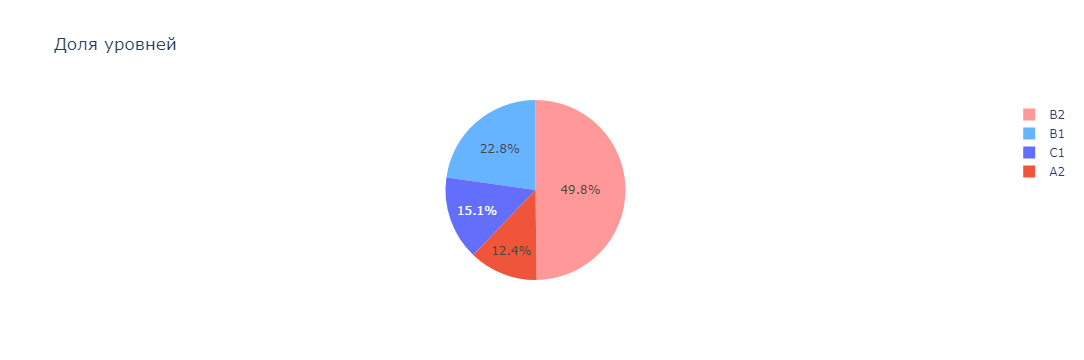

In [74]:
lvl_counts = df['Level'].value_counts()
labels = lvl_counts.index
values = lvl_counts.values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='percent', marker_colors=['#ff9999', '#66b3ff'])])
fig.update_layout(title='Доля уровней')
fig.show()

явный дисбаланс целевой переменной. B2 почти 50% и на остальные три класса соответсвенно 50. 

In [75]:
df['Subtitles'] = df['Subtitles'].astype(str)

Подготовим текст субтитров

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
regex = re.compile(r'[^\w\s]')

In [ ]:
def is_word_in_wordnet(word):
    return bool(wordnet.synsets(word))

In [76]:
def clean_text(input_text):

    clean_text = re.sub('<[^<]+?>|http\S+', '', input_text)
    clean_text = re.sub('\s+', ' ', clean_text.lower())
    clean_text = unicodedata.normalize('NFKD', clean_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    clean_text = re.sub('\d', '', clean_text)
    tokens = [token for token in word_tokenize(clean_text) if token not in stop_words and is_word_in_wordnet(token)]
    doc = nlp(' '.join(tokens))
    clean_text = ' '.join([token.lemma_ for token in doc if not token.is_punct])
    
    return clean_text

Здесь мы определеем набора стоп-слов и регулярного выражения для удаления пунктуации, затем проверяеми наличия слова в WordNetя:
Удаляет HTML-теги и URL-адреса из тек, п.
Приводит текст к нижнему регистру и нормализует про, ны.
Нормализует текст в ASCII, удаляя ак, уты.
мдаляет ифры.
Токемизирует текст и удаляет стоп-слова, оставляя только те слова, которые существуют в WordNet.
Лемммтизирует оставшиеся токенем, удаляя пунктуацию.

In [77]:
df['Subtitles'] = df['Subtitles'].apply(clean_text)

посмотрим что получилось

In [78]:
df['Subtitles'][0]

'fix synced enjoy flick clang drawer close inaudible cell phone ring ben phone please hang talk okay can believe leave come back please say talk look fight leave behind run away na help please newscaster detail elsewhere today power still restore many city southern seaboard wake afternoon widespread blackout inclement weather region problem seem link authority call catastrophic power crippled traffic area loud crash grunt tire screech scream glass shatter gasp groan horn honk inhale deeply sniff sigh gasp chain rattle breathe heavily grunt groan groan grunt sobs chain jangling sob breathe heavily damn clatter grunt rumble footstep approach pant gasp door creak okay okay please please please hurt breathing heavily please let go okay tell promise okay please let go please man need shock go go keep alive work get handy boyfriend expect send cop look sorry one look clang grunt groan softly grunt exhale scrape breathe heavily sigh cough fire alarm beep rapid footstep approach door open gasp

уже выглядит лучше.

Вытянем эмбеддинги с помощью предобученого Loginform, тк признак с субтитрами содежит объемные тексты.

In [79]:
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerModel.from_pretrained(model_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LongformerModel(
  (embeddings): LongformerEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (position_embeddings): Embedding(4098, 768, padding_idx=1)
  )
  (encoder): LongformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x LongformerLayer(
        (attention): LongformerAttention(
          (self): LongformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (query_global): Linear(in_features=768, out_features=768, bias=True)
            (key_global): Linear(in_features=768, out_features=768, bias=True)
            (value_global): Linear(in_features=768, out_features=768, bias=True)
          )
    

In [80]:
def get_longformer_embeddings(text, tokenizer, model, device, max_length=4096):

    encoded_input = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    last_hidden_state = outputs.last_hidden_state
    mean_hidden_state = torch.mean(last_hidden_state, dim=1)

    return mean_hidden_state

In [ ]:
embeddings = []
for text in df['Subtitles']:
    embedding = get_longformer_embeddings(text, tokenizer, model, device)
    embeddings.append(embedding.cpu().numpy())

In [81]:
df['Embeddings'] = embeddings

In [82]:
df['Embeddings']

0      [[0.010306962, -0.06400502, 0.09857493, 0.2033...
1      [[0.017886331, -0.116024464, 0.17595981, 0.402...
2      [[0.020556742, -0.116362885, 0.12219189, 0.201...
3      [[0.016475266, -0.13933457, 0.19372213, 0.2053...
4      [[0.031847354, -0.1145715, 0.16100839, 0.29140...
                             ...                        
254    [[-0.019169904, -0.04099044, 0.095776886, 0.12...
255    [[-0.016739806, -0.13530035, 0.17657182, 0.332...
256    [[0.017656276, -0.12234499, 0.17517784, 0.2777...
257    [[-0.021436872, 0.0009370707, 0.062310323, 0.0...
258    [[0.023738762, -0.1557531, 0.18199237, 0.34624...
Name: Embeddings, Length: 259, dtype: object

Необходимо преобразовать в 2D

In [83]:
X = np.array(df['Embeddings'].tolist()).reshape(df.shape[0], -1)

In [84]:
X.shape

(259, 768)

In [104]:
y = df['Level']

In [98]:
RS = 42

Разобъем на трейн/тест

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS, stratify=y)

Теперь подготовим целевую

In [109]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [110]:
X_train.shape

(207, 768)

In [111]:
X_test.shape

(52, 768)

#### Обучение моделей

Подберем параметры для трех моделей CatBoost, LGBM и SVC и будем использовать их в voiting ансамбле.

In [112]:
def objective_svc(trial):
    
    param = {
        'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'decision_function_shape': 'ovr',
        'class_weight': 'balanced',
        'random_state': RS
    }
    if param['kernel'] == 'poly':
        param['degree'] = trial.suggest_int('degree', 2, 5)
        param['coef0'] = trial.suggest_float('coef0', 0.0, 1.0)
    elif param['kernel'] == 'sigmoid':
        param['coef0'] = trial.suggest_float('coef0', 0.0, 1.0)
            
    svc = SVC(**param)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
    cv_scores = cross_val_score(svc, X_train, y_train, cv=skf, scoring=make_scorer(f1_score, average='weighted'))

    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return cv_scores.mean()

[I 2024-05-23 18:51:57,300] A new study created in memory with name: no-name-7f131829-ca58-4c56-9b4c-416a3023cfb2
[I 2024-05-23 18:51:57,468] Trial 0 finished with value: 0.6227536840626235 and parameters: {'C': 0.3149882822634529, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.6227536840626235.
[I 2024-05-23 18:51:57,607] Trial 1 finished with value: 0.2571988157937433 and parameters: {'C': 1.7054711797605124, 'kernel': 'sigmoid', 'gamma': 'scale', 'coef0': 0.7153859491819738}. Best is trial 0 with value: 0.6227536840626235.
[I 2024-05-23 18:51:57,747] Trial 2 finished with value: 0.6067370863684196 and parameters: {'C': 4.188971987986169, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.6227536840626235.
[I 2024-05-23 18:51:57,875] Trial 3 finished with value: 0.13715841649639557 and parameters: {'C': 13.141355197133834, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4, 'coef0': 0.254150379648857}. Best is trial 0 with value: 0.6227536840626235.
[

[I 2023-07-17 20:00:37,609] Trial 95 finished with value: 0.8889897156684816 and parameters: {'C': 5.531729511701387, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_uniform('C', 0.1, 10)
[I 2023-07-17 20:00:41,108] Trial 96 finished with value: 0.8889897156684816 and parameters: {'C': 8.521411219677004, 'kernel': 'linear'}. Best is trial 0 with value: 0.8889897156684816.
C:\Users\solov\AppData\Local\Temp\ipykernel_11856\1292188057.py:2: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  C = trial.suggest_

In [ ]:
study_svc = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study_svc.optimize(objective_svc, n_trials=200)
best_params_svc = study_svc.best_params

In [113]:
def objective_lgbm(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'objective': 'multiclass',
        'class_weight': 'balanced',
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
        'num_class': 4,
        'random_state': RS,
        'verbose': -1
    }

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_float('drop_rate', 0.1, 0.5)
        param['skip_drop'] = trial.suggest_float('skip_drop', 0.1, 0.5)
    
    lgbm = LGBMClassifier(**param)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)

    cv_scores = cross_val_score(lgbm, X_train, y_train, cv=skf, 
        scoring=make_scorer(f1_score, average='weighted'))
    
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return cv_scores.mean()

[I 2024-05-23 18:52:23,978] A new study created in memory with name: no-name-f139e07e-2ff7-44a4-850a-1174171b641a
[I 2024-05-23 18:52:30,751] Trial 0 finished with value: 0.6684586131022152 and parameters: {'learning_rate': 0.08028554350224083, 'n_estimators': 359, 'num_leaves': 79, 'boosting_type': 'gbdt', 'min_child_samples': 27, 'subsample': 0.6653793724577622, 'reg_lambda': 2.2429627507424645}. Best is trial 0 with value: 0.6684586131022152.
[I 2024-05-23 18:52:36,759] Trial 1 finished with value: 0.6887485906151063 and parameters: {'learning_rate': 0.02080194262239447, 'n_estimators': 259, 'num_leaves': 68, 'boosting_type': 'gbdt', 'min_child_samples': 21, 'subsample': 0.6023148316673224, 'reg_lambda': 2.255966476575178}. Best is trial 1 with value: 0.6887485906151063.
[I 2024-05-23 18:52:43,867] Trial 2 finished with value: 0.6465496485589552 and parameters: {'learning_rate': 0.008262118088388545, 'n_estimators': 459, 'num_leaves': 75, 'boosting_type': 'gbdt', 'min_child_samples'

In [ ]:
study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study_lgbm.optimize(objective_lgbm, n_trials=200)
best_params_lgbm = study_lgbm.best_params

In [115]:
def objective_cb(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'loss_function': 'MultiClass',
        'auto_class_weights': 'Balanced',
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'random_state': RS,
        'verbose': False
    }
    
    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 1, 20)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    cb = CatBoostClassifier(**param)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RS)
    cv_scores = cross_val_score(
        cb, X_train, y_train, cv=skf, scoring=make_scorer(f1_score, average='weighted'))
    
    if trial.should_prune():
        raise optuna.TrialPruned()
    
    return cv_scores.mean()

[I 2024-05-24 07:00:46,850] A new study created in memory with name: no-name-d20fea6f-05fd-48cc-bd7f-c0eaea2d18ff
[I 2024-05-24 07:10:44,014] Trial 0 finished with value: 0.7203422878035749 and parameters: {'iterations': 493, 'learning_rate': 0.053436980534074065, 'depth': 7, 'bootstrap_type': 'Bernoulli', 'colsample_bylevel': 0.3163548520653288, 'min_child_samples': 18, 'subsample': 0.9266526699072964}. Best is trial 0 with value: 0.7203422878035749.
[I 2024-05-24 07:13:33,168] Trial 1 finished with value: 0.7027310920349572 and parameters: {'iterations': 316, 'learning_rate': 0.05959665903412656, 'depth': 6, 'bootstrap_type': 'Bayesian', 'colsample_bylevel': 0.25319621180354235, 'min_child_samples': 15, 'bagging_temperature': 16.20025621506301}. Best is trial 0 with value: 0.7203422878035749.
[I 2024-05-24 08:20:30,815] Trial 2 finished with value: 0.6923275540415492 and parameters: {'iterations': 442, 'learning_rate': 0.0892555868699427, 'depth': 10, 'bootstrap_type': 'Bayesian', 'c

In [ ]:
study_cb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study_cb.optimize(objective_cb, n_trials=100)
best_params_cb = study_cb.best_params

Теперь когда параметры подобраны, создадим и обучим экземпляр ансамбля с мягким голосванием.

In [153]:
estimators = [
    ('lgbm', LGBMClassifier(**best_params_lgbm)),
    ('scv', SVC(**best_params_svc, probability=True)),
    ('cb', CatBoostClassifier(**best_params_cb))
]

In [154]:
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft'
)

In [155]:
voting_clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50877
[LightGBM] [Info] Number of data points in the train set: 207, number of used features: 768
[LightGBM] [Info] Start training from score -2.074622
[LightGBM] [Info] Start training from score -1.482571
[LightGBM] [Info] Start training from score -0.697990
[LightGBM] [Info] Start training from score -1.898732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(learning_rate=0.052104044995694945,
                                             min_child_samples=42,
                                             n_estimators=325, num_leaves=47,
                                             reg_lambda=0.0013986833786642577,
                                             subsample=0.6203802360996614)),
                             ('scv',
                              SVC(C=2.00929967391137, kernel='linear',
                                  probability=True)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x0000024794C3A0D0>)],
                 voting='soft')

In [192]:
joblib.dump(voting_clf, 'trained_voting_classifier.pkl')

['trained_voting_classifier.pkl']

Что мы максимизировать F1 - подберем порог для всех классов с помощью Optuna

In [164]:
y_proba = voting_clf.predict_proba(X_test)

In [165]:
num_classes = y_proba.shape[1]

In [166]:
best_thresholds = np.zeros(num_classes)
best_f1_scores = np.zeros(num_classes)

In [ ]:
def calculate_f1_for_threshold(y_true, y_proba, thresholds):
    y_pred_final = np.zeros_like(y_true)
    for i in range(num_classes):
        y_pred_final[y_proba[:, i] >= thresholds[i]] = i
    return f1_score(y_true, y_pred_final, average='weighted', zero_division=1), y_pred_final

In [ ]:
def objective(trial):
    thresholds = [trial.suggest_float(f'threshold_{i}', 0.1, 0.9) for i in range(num_classes)]
    f1, _ = calculate_f1_for_threshold(y_test, y_proba, thresholds)
    return f1

In [193]:
num_classes = len(np.unique(y_test))

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=3000)
best_thresholds = [study.best_trial.params[f'threshold_{i}'] for i in range(num_classes)]

[I 2024-05-28 16:07:01,464] A new study created in memory with name: no-name-ac9be8f3-d166-4fbb-a186-53f0350d6235
[I 2024-05-28 16:07:01,497] Trial 0 finished with value: 0.48385496144116835 and parameters: {'threshold_0': 0.4479050186404445, 'threshold_1': 0.24251324250716957, 'threshold_2': 0.8157196088810633, 'threshold_3': 0.7440759854194114}. Best is trial 0 with value: 0.48385496144116835.
[I 2024-05-28 16:07:01,507] Trial 1 finished with value: 0.5990338164251208 and parameters: {'threshold_0': 0.7996716426347747, 'threshold_1': 0.4755413489008673, 'threshold_2': 0.7043060000894851, 'threshold_3': 0.6432146300357255}. Best is trial 1 with value: 0.5990338164251208.
[I 2024-05-28 16:07:01,518] Trial 2 finished with value: 0.610105580693816 and parameters: {'threshold_0': 0.43683626283664123, 'threshold_1': 0.11260479151123058, 'threshold_2': 0.6679755141196051, 'threshold_3': 0.23525878411751072}. Best is trial 2 with value: 0.610105580693816.
[I 2024-05-28 16:07:01,529] Trial 3 

Best Thresholds for each class: [0.7843155999708554, 0.4217912081902047, 0.40527455195710455, 0.4507301903042614]
Best F1 Score: 0.67

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.55      0.50      0.52        12
           2       0.66      0.81      0.72        26
           3       1.00      0.62      0.77         8

    accuracy                           0.67        52
   macro avg       0.74      0.61      0.65        52
weighted avg       0.69      0.67      0.67        52



In [ ]:
print('Лучший порог', best_thresholds)
print(f"F1: {study.best_value:.2f}")

Лучшие пороги: [0.7843155999708554, 0.4217912081902047, 0.40527455195710455, 0.4507301903042614]

 F1: 0.67

In [ ]:
_, best_y_pred_final = calculate_f1_for_threshold(y_test, y_proba, best_thresholds)

report = classification_report(y_test, best_y_pred_final, labels=np.arange(num_classes), zero_division=1)
print("\nClassification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.55      0.50      0.52        12
           2       0.66      0.81      0.72        26
           3       1.00      0.62      0.77         8

    accuracy                           0.67        52
   macro avg       0.74      0.61      0.65        52
weighted avg       0.69      0.67      0.67        52

Отчетливо видно что модель хуже всего справляется с классом 1(В1) низкие полнота и точность и соответвенно F1, и классом 0(А2) - низкая полнота и F1. Если во втором случае играет роль что примеров класса мало, то в случае с В1 - модель допускает ошибки и не правильно классифицирует объекты.

In [194]:
np.save('best_thresholds.npy', best_thresholds)

Теперь посмотрим на ошибки

In [197]:
y_pred = voting_clf.predict(X_test)

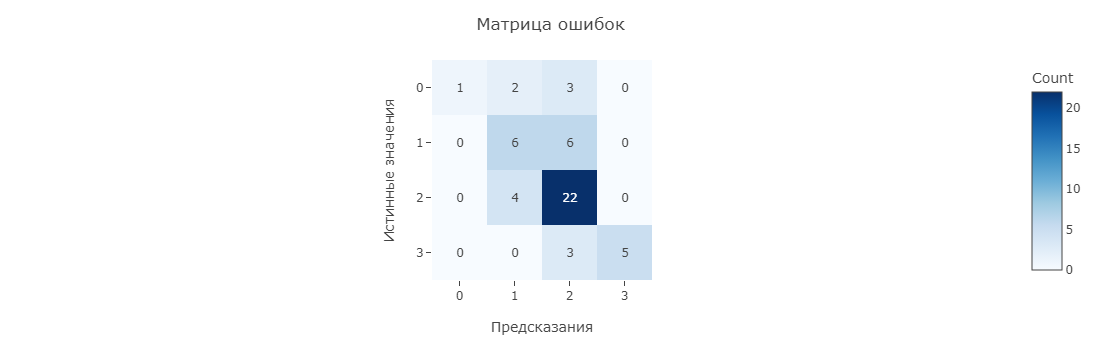

In [198]:
conf_matrix = confusion_matrix(y_test, y_pred)


class_names = [0, 1, 2, 3]

fig = px.imshow(
    conf_matrix,
    labels=dict(x='Predicted', y='True', color='Count'),
    x=class_names,
    y=class_names,
    text_auto=True,
    color_continuous_scale='Blues'
)
fig.update_layout(
    title='Матрица ошибок',
    xaxis_title='Предсказания',
    yaxis_title='Истинные значения'
)
fig.show()

Класс 0 является самым проблемным для модели, так как ни одно предсказание не было верным.
Класс 1: Модель имеет 50% точность для этого класса (6 из 12).
Класс 2: Модель хорошо справляется с этим классом, предсказывая верно в 22 из 26 случаев.
Класс 3: Модель также имеет неплохую точность (5 из 8). В 0 и 1, вжно, сяони имеюпризнаки в эмбедингах для классов 0 и 1 между собой и признаки с другими. Получилось что чем проще текст - тем хуже он классифицируется.классами.

#### Вывод

В ходе выполнения задачи, самую большую сложность представляет этап предобработки субтитров в список существующих слов, без всех посторонних символов. Но у нас получилось тут все сделать отлично. Дальше извлечение эмбедингов. Поскольку признак получился очень громозким - использовали Logformer, наверно онда из лучших предобученных моделей для больших текстов. С подобранными параметрыми и порогом и используя ансанблять SVC, CatBoost(оставил только из за лучшего качества, очень не торопливый бустинг), Lgbm(лучший) - получили итоговый F1(для всех классов) - 0.67. Модель плохо справляется с первыми двумя уровнями A2 и B1. Данные размечались вручную эксператми с использованием Оксфордских словарей. Размеченных данных очень мало, дисбаланс, поэтому результат не иделаьный. Рекомендация - разметить хотя бы несколько тысяч ( лучше больше 10) текстов и повторить эксперимент. Протестируем streamlit приложение на этой модели 